<a href="https://colab.research.google.com/github/Lexie-D/Breast-Cancer-Classification/blob/main/Breast_Cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load the libraries

In [3]:
#Libraries
import pandas as pd
import numpy as np
import os
import random
import cv2

#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Viz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

#Image
import PIL.Image
from PIL import Image
from PIL import ImageOps
from IPython.display import display

#Tensor flow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



import requests
import zipfile
import io
import glob

# 2. Load the Dataset

In [4]:
#Uploading the dataset
from google.colab import files
uploaded = files.upload()

Saving Dataset_BUSI_with_GT.zip to Dataset_BUSI_with_GT.zip


In [5]:
#Unzipping the file
zip_path = "Dataset_BUSI_with_GT.zip"
extract_to = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

#confirm location
extracted_path = os.path.join(extract_to, "Dataset_BUSI_with_GT")
print(extracted_path)

/content/Dataset_BUSI_with_GT


In [6]:
os.listdir(extracted_path)

['malignant', 'benign', 'normal']

# 3. Read and Explore the dataset

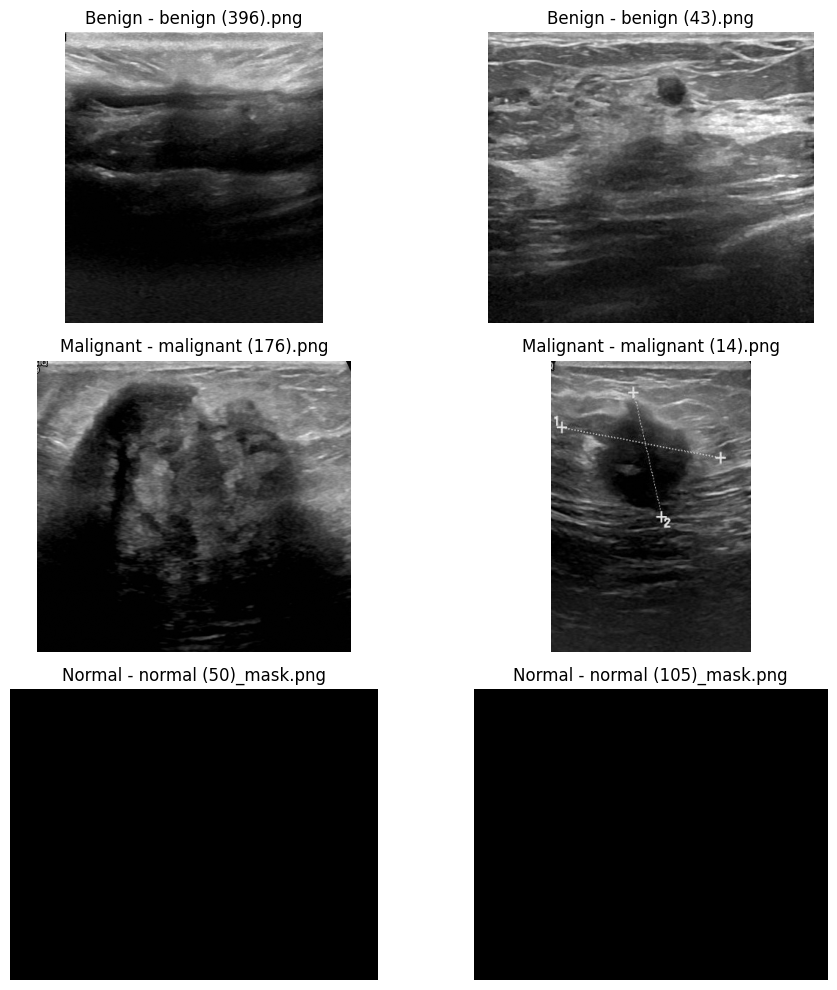

In [7]:
dataset_path = "/content/Dataset_BUSI_with_GT"
categories = ['benign', 'malignant', 'normal']

fig, axs = plt.subplots(len(categories), 2, figsize = (10, 10))

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    selected = random.sample(image_files, 2)

    for j in range(2):
        img = os.path.join(category_path, selected[j])
        img = Image.open(img).convert('L')  #images are all grey scale
        axs[i, j].imshow(img, cmap = 'grey')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'{category.capitalize()} - {selected[j]}')

plt.tight_layout()
plt.show()

In [8]:
pd.DataFrame(
    os.listdir(extracted_path),
    columns = ['File Name']
)

,File Name
0,malignant
1,benign
2,normal


## All the paths in "extracted_path"

In [9]:
train_data = "/content/Dataset_BUSI_with_GT"

In [10]:
# Get all image file paths from subfolders
train_files = glob.glob(os.path.join(train_data, "*", "*.*"))

# Randomly shuffle the lists
random.shuffle(train_files)

# Extract labels from the directory names
labels = [os.path.basename(os.path.dirname(path)) for path in train_files]

# Create list of tuples (file path, label)
data = list(zip(train_files, labels))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Path", "Label"])

df

,Path,Label
0,/content/Dataset_BUSI_with_GT/normal/normal (6...,normal
1,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
2,/content/Dataset_BUSI_with_GT/benign/benign (7...,benign
3,/content/Dataset_BUSI_with_GT/normal/normal (8...,normal
4,/content/Dataset_BUSI_with_GT/benign/benign (2...,benign
...,...,...
1573,/content/Dataset_BUSI_with_GT/benign/benign (6...,benign
1574,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
1575,/content/Dataset_BUSI_with_GT/normal/normal (4...,normal
1576,/content/Dataset_BUSI_with_GT/benign/benign (4...,benign


# 4. Data Visualizations
# Distribution of Categories (3)

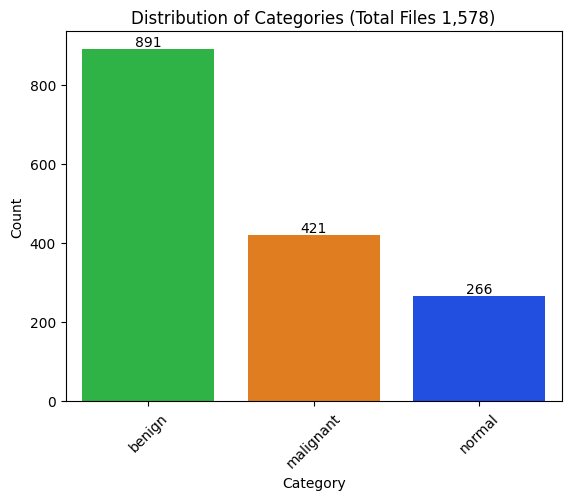

In [11]:
# Descending order
label_order = df['Label'].value_counts().sort_values(ascending = False).index

# Countplot
ax = sns.countplot(x = 'Label', data = df, order = label_order, hue = 'Label', palette = 'bright', legend = False)

# Display the counts per category above bars
for container in ax.containers:
  ax.bar_label(container)

# Plot
ax.set_title('Distribution of Categories (Total Files 1,578)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Collect Data Paths and Labels

In [12]:
# Path to "parent" dataset folder
dataset_path = "/content/Dataset_BUSI_with_GT"

# All image file paths
image_paths = glob.glob(os.path.join(dataset_path, "*", "*.png"))

# Shuffle the paths
np.random.shuffle(image_paths)

# All labels
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Create DataFrame
df = pd.DataFrame({
    'Path': image_paths,
    'Label': labels
})

df.head()

,Path,Label
0,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
1,/content/Dataset_BUSI_with_GT/normal/normal (5...,normal
2,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
3,/content/Dataset_BUSI_with_GT/normal/normal (4...,normal
4,/content/Dataset_BUSI_with_GT/benign/benign (4...,benign


# 5. Data Preprocessing

## Using pretrained model **DenseNet121** for this project
- Best for medical imaging, smallerish datasets, and gives higher accuracy
- Images are greyscale, but with the chosen pretrained model, set to RGB
- Works best if image_size is (224, 224)

In [13]:
#set constants
image_size = (224, 224)
batch_size = 32
random_state = 42

## Split the Dataset
- 70% train
- 15% validation
- 15% test

In [14]:
# Split into training-test and validation-test sets
train_val_df, test_df = train_test_split(df, test_size = 0.15, stratify = df['Label'], random_state = 42)

# Split validation-test set into validation and test sets
val_df, train_df = train_test_split(train_val_df, test_size = 0.5, stratify = train_val_df['Label'], random_state = 42)

## Image Generator

In [15]:
# Defining image settings
image_size = (224, 224)
batch_size = 32
seed = 42

# Creating data generators
train_datagen = ImageDataGenerator(
    rescale = 1./255,               #normalize the pixel values [0,1]
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

# Creating generators, for train, validation, and test using flow_from_dataframe
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = image_size,
    color_mode = 'rgb',          #have to use RBG with DenseNet112
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batch_size,
    seed = seed
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = image_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batch_size,
    seed = seed
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = image_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batch_size,
    seed = seed
)


Found 671 validated image filenames belonging to 3 classes.
Found 670 validated image filenames belonging to 3 classes.
Found 237 validated image filenames belonging to 3 classes.


In [16]:
print(train_gen.class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


# 6. Build the Model (DenseNet121)

In [17]:
base_model = DenseNet121(
    weights = 'imagenet',  #loaded with library
    include_top = False,
    input_shape = (224, 224, 3)
)

# Freeze layers of pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential()

# Add pre-trained model (DenseNet121)
model.add(base_model)

# Flatten the output of the base model
model.add(Flatten())

# Add fully connected layers with dropout to regularize it
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

# Softmax layer for 3-way classification
model.add(Dense(3, activation = 'softmax'))

# Show model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    51,381,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,059,203 (229.11 MB)

 Trainable params: 53,021,699 (202.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

## Visualize the Convolutional Neural Network

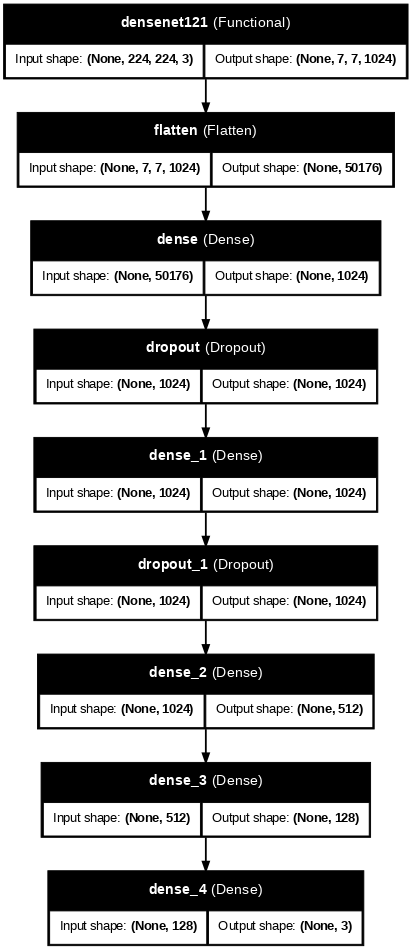

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image as IPImage

model_visualization_path = "/content/cnn_architecture.png"
plot_model(model, to_file = model_visualization_path, show_shapes = True, show_layer_names = True, dpi = 65)

IPImage(filename=model_visualization_path)

## Create Checkpoints and Callbacks to Save the Best Performing Model

In [19]:
# Where the best model will be saved
checkpoint_path = "/content/best_model.h5"

# Define the callbacks
callbacks = [
    ModelCheckpoint(
        filepath = checkpoint_path,
        save_best_only = True,
        monitor = 'val_accuracy',
        save_weights_only = False,
        verbose = 1
    ),
    EarlyStopping(
        monitor = 'val_accuracy',
        patience = 5,
        restore_best_weights = True,
        verbose = 1
    ),
    ReduceLROnPlateau(            # reducing the learn rate
        monitor = 'val_loss',
        factor = 0.5,             # how much multi lr by
        patience = 3,             # 3 epochs
        verbose = 1
    )
]

# 7. Compile the Model

In [20]:
# Compile
model.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# 8. Train the Model

In [21]:
history = model.fit(
    train_gen,
    steps_per_epoch = len(train_gen),
    epochs = 10,
    validation_data = val_gen,
    validation_steps = len(val_gen),
    callbacks = callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4203 - loss: 6.8905
Epoch 1: val_accuracy improved from -inf to 0.64478, saving model to /content/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.4242 - loss: 6.7907 - val_accuracy: 0.6448 - val_loss: 1.0965 - learning_rate: 0.0010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6546 - loss: 1.7296
Epoch 2: val_accuracy improved from 0.64478 to 0.75373, saving model to /content/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6546 - loss: 1.7234 - val_accuracy: 0.7537 - val_loss: 0.5903 - learning_rate: 0.0010
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7637 - loss: 0.7493
Epoch 3: val_accuracy improved from 0.75373 to 0.79254, saving model to /content/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7635 - loss: 0.7485 - val_accuracy: 0.7925 - val_loss: 0.4281 - learning_rate: 0.0010
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7507 - loss: 0.5969
Epoch 4: val_accuracy improved from 0.79254 to 0.80746, saving model to /content/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7510 - loss: 0.5953 - val_accuracy: 0.8075 - val_loss: 0.4348 - learning_rate: 0.0010
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8077 - loss: 0.4981
Epoch 5: val_accuracy improved from 0.80746 to 0.85224, saving model to /content/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8071 - loss: 0.4968 - val_accuracy: 0.8522 - val_loss: 0.3717 - learning_rate: 0.0010
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8035 - loss: 0.4404
Epoch 6: val_accuracy did not improve from 0.85224
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 686ms/step - accuracy: 0.8044 - loss: 0.4404 - val_accuracy: 0.7940 - val_loss: 0.4041 - learning_rate: 0.0010
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7976 - loss: 0.4451
Epoch 7: val_accuracy improved from 0.85224 to 0.86418, saving model to /content/best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7981 - loss: 0.4443 - val_accuracy: 0.8642 - val_loss: 0.3657 - learning_rate: 0.0010
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8267 - loss: 0.3926
Epoch 8: val_accuracy did not improve from 0.86418
21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 684ms/step - accuracy: 0.8265 - loss: 0.3936 - val_accuracy: 0.8552 - val_loss: 0.3604 - learning_rate: 0.0010
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8304 - loss: 0.4219
Epoch 9: val_accuracy did not improve from 0.86418
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 683ms/step - accuracy: 0.8310 - loss: 0.4204 - val_accuracy: 0.8433 - val_loss: 0.3572 - learning_rate: 0.0010
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8329 - loss: 0.3997
Epoch 10: val_accuracy did not improve from 0.86418
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 762ms/step - accuracy: 0.8331 - loss: 0.3995 - val_accuracy: 0.8627 - val_loss: 0.3542 - learning_rate: 0.0010
Restoring model weight

## Show the Training Results

In [22]:
# Creat a pandas dataframe to contain training hhistory metrics of the model
train_history = pd.DataFrame(history.history)

# Add new column for epoch number
train_history['Epoch'] = range(1, len(train_history) + 1)

# Order columns
train_history = train_history[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]

train_history

,Epoch,loss,accuracy,val_loss,val_accuracy
0,1,4.695199,0.506706,1.096474,0.644776
1,2,1.591763,0.654247,0.590308,0.753731
2,3,0.733145,0.760060,0.428097,0.792537
3,4,0.561423,0.758569,0.434794,0.807463
4,5,0.468022,0.794337,0.371666,0.852239
5,6,0.440856,0.824143,0.404088,0.794030
6,7,0.427279,0.807750,0.365658,0.864179
7,8,0.412784,0.822653,0.360351,0.855224
8,9,0.389084,0.843517,0.357155,0.843284
9,10,0.396876,0.836066,0.354187,0.862687


## Plot the Training Results

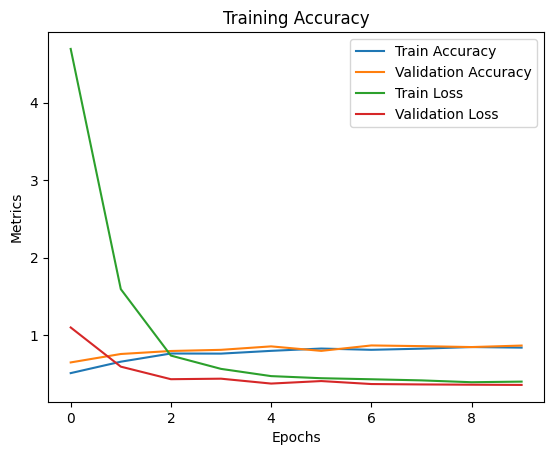

In [25]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Accuracy')
plt.show()

# 9. Evaluate the Modle with Test Set

In [26]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8814 - loss: 0.3324
Test Accuracy: 0.8819, Test Loss: 0.3221


In [30]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

# create pandas dataframe with all 3
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Accuracy': [train_accuracy, val_accuracy, test_acc],
    'Loss': [train_loss, val_loss, test_loss]
    })

evaluation_results

,Set,Accuracy,Loss
0,Train,0.836066,0.396876
1,Validation,0.862687,0.354187
2,Test,0.881857,0.322138
